Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 2: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [9]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy
from tqdm.notebook import tqdm


## The *Nim* and *Nimply* classes

In [10]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [11]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Sample (and silly) startegies 

In [12]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [13]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [14]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


In [15]:
import numpy as np

def my_strategy(state: Nim, weights) -> Nimply:
    #spicy_moves = [Nimply(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    spicy_moves = [Nimply(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) if c > 0]
    # for each value of weights, assign a decision to take
    #       for example:
    #       0: take all the elements from the row with the most objects
    #       1: take one item from the row with less objects
    #       else: take a random row
    
    rule = np.random.choice(len(weights), p=weights)
    if rule == 0:
        return max(spicy_moves, key=lambda move: move.num_objects)
    if rule == 1:
        return min(spicy_moves, key=lambda move: move.num_objects)
    return random.choice(spicy_moves)

  0%|          | 0/300 [00:00<?, ?it/s]

Best weights: [0.09152543 0.63188589 0.27658868], fitness: 55.00000000000001, sigma: 1
Best weights: [0.40843862 0.35189881 0.23966257], fitness: 60.0, sigma: 0.20740671020376797
Best weights: [0.4857929  0.13839349 0.37581362], fitness: 65.0, sigma: 0.4373876900904402
Best weights: [0.67328376 0.08502709 0.24168915], fitness: 75.0, sigma: 0.37412571886063617
Best weights: [0.4690521  0.36782033 0.16312757], fitness: 80.0, sigma: 0.26912649831485047
Best weights: [0.4690521  0.36782033 0.16312757], fitness: 80.0, sigma: 0.26912649831485047


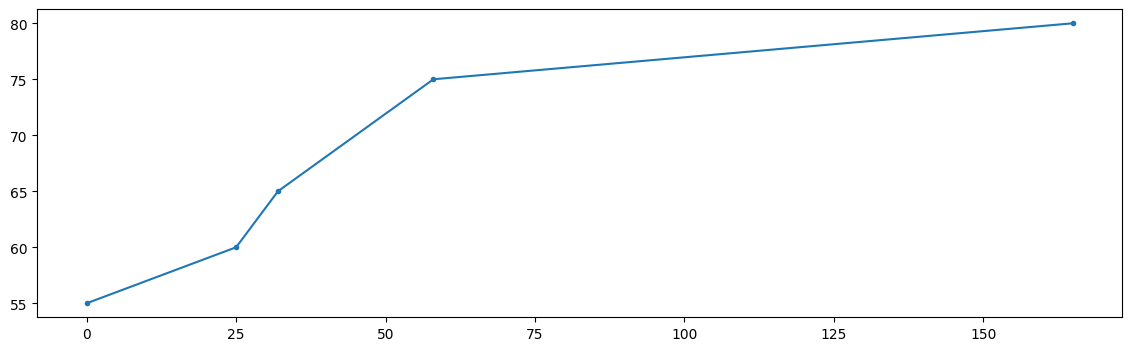

In [16]:
from matplotlib import pyplot as plt

mu = 5  # number of population
lamb = 5 * mu  # size of children
sigma = 1  # mutation strength
trainings = 20  # number of training games per candidate
N_ROWS = 5  # number of rows in the game

strategy = (optimal, my_strategy)

def fitness( weights) -> float:
    """The fitness function"""
    win_cnt = 0 # number of wins for the candidate
    for _ in range(trainings):
        nim =  Nim(N_ROWS)
        player = 0
        while nim:
            if player == 0:
                ply = strategy[player](nim)
            else:
                ply = strategy[player](nim, weights)
            nim.nimming(ply)
            player = 1 - player
        if player == 1:
            win_cnt += 1
    return win_cnt / trainings * 100

def mutation(P):
    """Mutate the population"""
    offspring = []
    for i in P:
        for _ in range(lamb//mu):
            sigma = np.abs(np.random.normal(loc=i[2], scale=0.2))
            mutated_weights = np.abs(np.random.normal(loc=i[0], scale=sigma))
            mutated_weights /= sum(mutated_weights) #normalizing weights
            mutated_fitness = fitness(mutated_weights)
            offspring.append((mutated_weights, mutated_fitness, sigma))
    return offspring

def ES():
    P = []
    history = list()
    
    #initialize population
    for _ in range(mu):
        weights = np.random.dirichlet(np.ones(3))   # because I'm using 3 rules
        fit = fitness(weights)
        # print(fit)
        P.append((weights, fit, sigma))
    
    Best = None
    for step in tqdm(range(300)):
        offspring = P + mutation(P)
        offspring = sorted(offspring, key=lambda i : i[1])
        if Best is None or offspring[-1][1] > Best[1]:
            Best = offspring[-1]
            print(f"Best weights: {Best[0]}, fitness: {Best[1]}, sigma: {Best[2]}")
            history.append((step, Best[1]))
        P = offspring[-mu :]
    history = np.array(history)
    plt.figure(figsize=(14, 4))
    plt.plot(history[:, 0], history[:, 1], marker=".")
    return Best    
        
genome = ES()
print(f"Best weights: {genome[0]}, fitness: {genome[1]}, sigma: {genome[2]}")

#ottengo un risultato strano in fitness, non é che non va bene che non faccio copy?

def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    return my_strategy(state, genome[0])


## Oversimplified match

In this version of the nim game, the loser is the last player to take the last item. So, the goal of the player is to avoid taking the last item.

In [17]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, adaptive)

nim = Nim(N_ROWS)

logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")

cnt = 0

for _ in range(100):
    nim = Nim(N_ROWS)
    # logging.info(f"init : {nim}")
    player = 0
    while nim:
        ply = strategy[player](nim)
        # logging.info(f"ply: player {player} plays {ply}")
        nim.nimming(ply)
        # logging.info(f"status: {nim}")
        player = 1 - player
    # logging.info(f"status: Player {player} won!")
    if player == 1:
        cnt += 1
logging.info(f"Winning percentage {cnt}")

INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=4)
INFO:root:status: <1 3 5 7 5>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=3)
INFO:root:status: <1 0 5 7 5>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=2)
INFO:root:status: <1 0 5 5 5>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 0 5 5 5>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=1)
INFO:root:status: <0 0 5 5 4>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=1)
INFO:root:status: <0 0 4 5 4>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 0 4 4 4>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=3)
INFO:root:status: <0 0 4 4 1>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=4)
INFO:root:status: <0 0 0 4 1>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 0 0 3 1>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 0